# Customer Churn

## Goal: 
* Determine the cause of customers churning
* Build a model that will predict reasons why customers might be churning


#### ----------------------------------------Imports----------------------------------------


In [58]:
from env import get_connection
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import scipy.stats as stats
from scipy import stats
# turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")

# import our own acquire module
import acquire
#import my own prepare module
import prepare


#### ----------------------------------------Acquiring the data----------------------------------------

In [59]:
df = acquire.get_telco_data()

#### ----------------------------------------Checking the data----------------------------------------

In [60]:
df.head()

,Unnamed: 0,payment_type_id,contract_type_id,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type
0,0,2,2,1,0002-ORFBO,Female,0,Yes,Yes,9,...,Yes,Yes,No,Yes,65.6,593.3,No,DSL,One year,Mailed check
1,1,2,1,1,0003-MKNFE,Male,0,No,No,9,...,No,No,Yes,No,59.9,542.4,No,DSL,Month-to-month,Mailed check
2,2,1,1,2,0004-TLHLJ,Male,0,No,No,4,...,No,No,No,Yes,73.9,280.85,Yes,Fiber optic,Month-to-month,Electronic check
3,3,1,1,2,0011-IGKFF,Male,1,Yes,No,13,...,No,Yes,Yes,Yes,98.0,1237.85,Yes,Fiber optic,Month-to-month,Electronic check
4,4,2,1,2,0013-EXCHZ,Female,1,Yes,No,3,...,Yes,Yes,No,Yes,83.9,267.4,Yes,Fiber optic,Month-to-month,Mailed check


#### ----------------------------------------Checking the datatypes----------------------------------------

In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Unnamed: 0                7043 non-null   int64  
 1   payment_type_id           7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   internet_service_type_id  7043 non-null   int64  
 4   customer_id               7043 non-null   object 
 5   gender                    7043 non-null   object 
 6   senior_citizen            7043 non-null   int64  
 7   partner                   7043 non-null   object 
 8   dependents                7043 non-null   object 
 9   tenure                    7043 non-null   int64  
 10  phone_service             7043 non-null   object 
 11  multiple_lines            7043 non-null   object 
 12  online_security           7043 non-null   object 
 13  online_backup             7043 non-null   object 
 14  device_p

#### ----------------------------------------Dropping unnecessary columns----------------------------------------

In [62]:
df.drop(columns = ['Unnamed: 0', 'payment_type_id', 'contract_type_id', 'customer_id', 'gender', 
                   'senior_citizen', 'partner', 'dependents', 'phone_service', 'multiple_lines',
                   'streaming_tv', 'streaming_movies', 'contract_type', 'payment_type'], inplace = True)


#### ----------------------------------------Checking to see my remaining columns----------------------------------------

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   internet_service_type_id  7043 non-null   int64  
 1   tenure                    7043 non-null   int64  
 2   online_security           7043 non-null   object 
 3   online_backup             7043 non-null   object 
 4   device_protection         7043 non-null   object 
 5   tech_support              7043 non-null   object 
 6   paperless_billing         7043 non-null   object 
 7   monthly_charges           7043 non-null   float64
 8   total_charges             7043 non-null   object 
 9   churn                     7043 non-null   object 
 10  internet_service_type     7043 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 605.4+ KB


#### ----------------------------------------Checking how many customers have churned----------------------------------------

In [64]:
pd.DataFrame(df.churn.value_counts())

,churn
No,5174
Yes,1869


- 1869, or 26.5% of customers have churned 

#### ----------------------------------------Checking to see how many customers have DSL, fiber and no internet service----------------------------------------

In [65]:
df.internet_service_type.value_counts()

Fiber optic    3096
DSL            2421
None           1526
Name: internet_service_type, dtype: int64

#### ----------------------------------------Checking to see if there are any null values in the dataset----------------------------------------

In [66]:
df.isna().any()

internet_service_type_id    False
tenure                      False
online_security             False
online_backup               False
device_protection           False
tech_support                False
paperless_billing           False
monthly_charges             False
total_charges               False
churn                       False
internet_service_type       False
dtype: bool

#### ----------------------------------------Using describe to get a feel of some of the data----------------------------------------

In [67]:
df.describe()

,internet_service_type_id,tenure,monthly_charges
count,7043.000000,7043.000000,7043.000000
mean,1.872923,32.371149,64.761692
std,0.737796,24.559481,30.090047
min,1.000000,0.000000,18.250000
25%,1.000000,9.000000,35.500000
50%,2.000000,29.000000,70.350000
75%,2.000000,55.000000,89.850000
max,3.000000,72.000000,118.750000


#### ----------------------------------------Preparing the data----------------------------------------
 - removing all whitespace from total charges to convert to a float

In [68]:
df.total_charges = df.total_charges.str.strip()

* reassigning the dataframe to remove rows with no value

In [69]:
df = df[df.total_charges != ""]

* reassigning the total_charges column from a str to a float

In [70]:
df.total_charges = df.total_charges.astype(float)

* Getting info to see what columns are object to creat dummies for binary readability

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   internet_service_type_id  7032 non-null   int64  
 1   tenure                    7032 non-null   int64  
 2   online_security           7032 non-null   object 
 3   online_backup             7032 non-null   object 
 4   device_protection         7032 non-null   object 
 5   tech_support              7032 non-null   object 
 6   paperless_billing         7032 non-null   object 
 7   monthly_charges           7032 non-null   float64
 8   total_charges             7032 non-null   float64
 9   churn                     7032 non-null   object 
 10  internet_service_type     7032 non-null   object 
dtypes: float64(2), int64(2), object(7)
memory usage: 659.2+ KB


#### ----------------------------------------Creating dummy variables for the columns that were object datatypes----------------------------------------

In [72]:
dummy_df = pd.get_dummies(df[['online_security','online_backup', 'device_protection', 
                        'tech_support', 'paperless_billing', 'churn', 'internet_service_type']], dummy_na=False, drop_first=[True, True])
dummy_df.head()


,online_security_No internet service,online_security_Yes,online_backup_No internet service,online_backup_Yes,device_protection_No internet service,device_protection_Yes,tech_support_No internet service,tech_support_Yes,paperless_billing_Yes,churn_Yes,internet_service_type_Fiber optic,internet_service_type_None
0,0,0,0,1,0,0,0,1,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,1,1,1,0
3,0,0,0,1,0,1,0,0,1,1,1,0
4,0,0,0,0,0,0,0,1,1,1,1,0


#### ----------------------------------------Combining the original df with the dummy variables that were created----------------------------------------


In [73]:
df = pd.concat([df, dummy_df], axis=1)
df.head(1)

,internet_service_type_id,tenure,online_security,online_backup,device_protection,tech_support,paperless_billing,monthly_charges,total_charges,churn,...,online_backup_No internet service,online_backup_Yes,device_protection_No internet service,device_protection_Yes,tech_support_No internet service,tech_support_Yes,paperless_billing_Yes,churn_Yes,internet_service_type_Fiber optic,internet_service_type_None
0,1,9,No,Yes,No,Yes,Yes,65.6,593.3,No,...,0,1,0,0,0,1,1,0,0,0


In [74]:
df.drop(columns = ['online_security','online_backup', 'device_protection', 
                        'tech_support', 'paperless_billing', 'churn', 'internet_service_type'], inplace = True)


In [75]:
df.head()

,internet_service_type_id,tenure,monthly_charges,total_charges,online_security_No internet service,online_security_Yes,online_backup_No internet service,online_backup_Yes,device_protection_No internet service,device_protection_Yes,tech_support_No internet service,tech_support_Yes,paperless_billing_Yes,churn_Yes,internet_service_type_Fiber optic,internet_service_type_None
0,1,9,65.6,593.30,0,0,0,1,0,0,0,1,1,0,0,0
1,1,9,59.9,542.40,0,0,0,0,0,0,0,0,0,0,0,0
2,2,4,73.9,280.85,0,0,0,0,0,1,0,0,1,1,1,0
3,2,13,98.0,1237.85,0,0,0,1,0,1,0,0,1,1,1,0
4,2,3,83.9,267.40,0,0,0,0,0,0,0,1,1,1,1,0


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 16 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   internet_service_type_id               7032 non-null   int64  
 1   tenure                                 7032 non-null   int64  
 2   monthly_charges                        7032 non-null   float64
 3   total_charges                          7032 non-null   float64
 4   online_security_No internet service    7032 non-null   uint8  
 5   online_security_Yes                    7032 non-null   uint8  
 6   online_backup_No internet service      7032 non-null   uint8  
 7   online_backup_Yes                      7032 non-null   uint8  
 8   device_protection_No internet service  7032 non-null   uint8  
 9   device_protection_Yes                  7032 non-null   uint8  
 10  tech_support_No internet service       7032 non-null   uint8  
 11  tech

#### ----------------------------------------Getting rid of another useless column----------------------------------------

In [77]:
df.drop(columns = ['internet_service_type_id'], inplace = True)

In [78]:
df.head()

,tenure,monthly_charges,total_charges,online_security_No internet service,online_security_Yes,online_backup_No internet service,online_backup_Yes,device_protection_No internet service,device_protection_Yes,tech_support_No internet service,tech_support_Yes,paperless_billing_Yes,churn_Yes,internet_service_type_Fiber optic,internet_service_type_None
0,9,65.6,593.30,0,0,0,1,0,0,0,1,1,0,0,0
1,9,59.9,542.40,0,0,0,0,0,0,0,0,0,0,0,0
2,4,73.9,280.85,0,0,0,0,0,1,0,0,1,1,1,0
3,13,98.0,1237.85,0,0,0,1,0,1,0,0,1,1,1,0
4,3,83.9,267.40,0,0,0,0,0,0,0,1,1,1,1,0


#### ----------------------------------------Making all the columns lowercase----------------------------------------

In [79]:
df.columns = df.columns.str.lower()
df.head()

,tenure,monthly_charges,total_charges,online_security_no internet service,online_security_yes,online_backup_no internet service,online_backup_yes,device_protection_no internet service,device_protection_yes,tech_support_no internet service,tech_support_yes,paperless_billing_yes,churn_yes,internet_service_type_fiber optic,internet_service_type_none
0,9,65.6,593.30,0,0,0,1,0,0,0,1,1,0,0,0
1,9,59.9,542.40,0,0,0,0,0,0,0,0,0,0,0,0
2,4,73.9,280.85,0,0,0,0,0,1,0,0,1,1,1,0
3,13,98.0,1237.85,0,0,0,1,0,1,0,0,1,1,1,0
4,3,83.9,267.40,0,0,0,0,0,0,0,1,1,1,1,0


#### ----------------------------------------Splitting the data----------------------------------------

In [80]:
train, validate, test = prepare.train_val_test(df, 'churn_yes')

#### ----------------------------------------Checking the size of the train, validate and test datasets----------------------------------------

In [81]:
train.shape, validate.shape, test.shape

((4922, 15), (1688, 15), (422, 15))

#### ----------------------------------------Creating a varriable dataframe for nonbinary values and churn count----------------------------------------

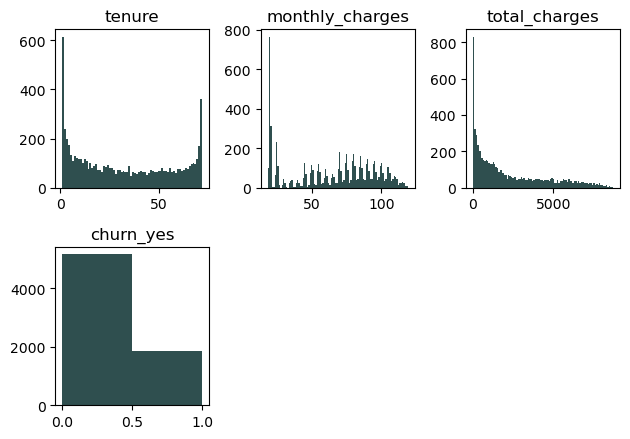

In [82]:
df_nonbinary= df[['tenure', 'monthly_charges', 'total_charges', 'churn_yes']]

for i in range(df_nonbinary.shape[1]):
    plt.subplot(6, 3, i + 1)
    f = plt.gca()
    f.set_title(df_nonbinary.columns.values[i])

    vals = np.size(df_nonbinary.iloc[:, i].unique())
    if vals >= 100:
        vals = 100
    
    plt.hist(df_nonbinary.iloc[:, i], bins=vals, color = 'darkslategray')
plt.tight_layout(rect=[0, 0.3, 1, 3])

### Establishing my hypothesis for my T-Test
- H
0
: Mean of monthly charges of churned customers <= Mean of monthly charges of customers who haven't churned
- H
a
: Mean of monthly charges of churned customers > Mean of monthly charges of customers who haven't churned

<AxesSubplot:>

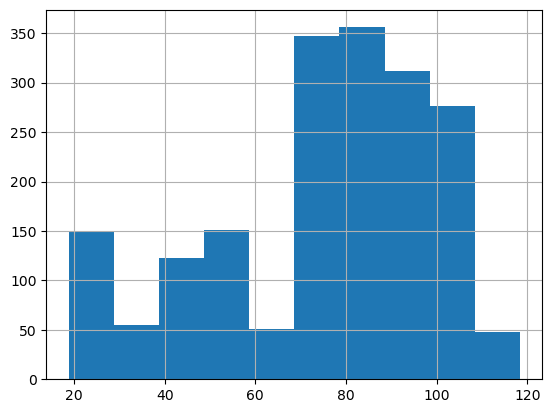

In [83]:
churned_price = df[df.churn_yes == True].monthly_charges

churned_price.hist()

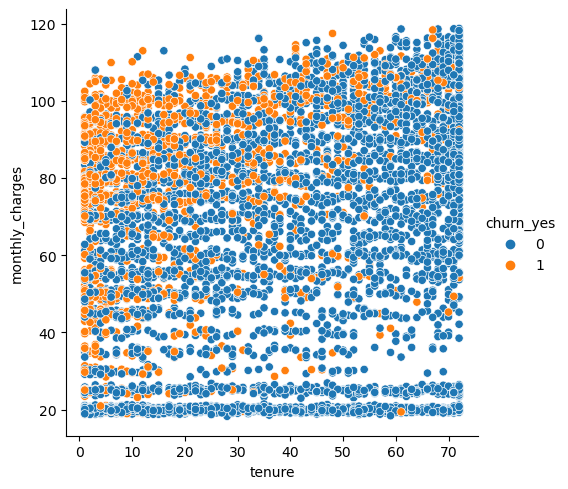

In [84]:


sns.relplot(x = df.tenure, y = df.monthly_charges, hue = 'churn_yes', data = df)

<AxesSubplot:>

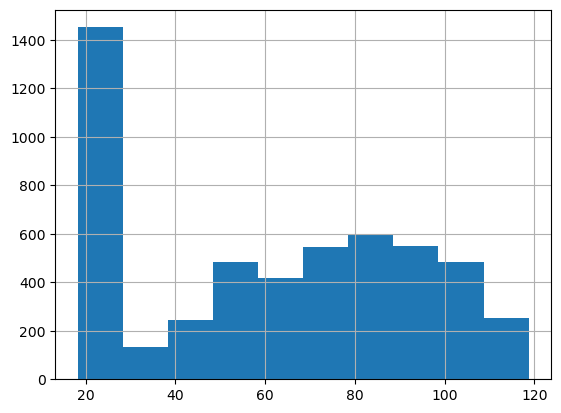

In [85]:
churn_no_price = df[df.churn_yes == False].monthly_charges

churn_no_price.hist()

In [86]:
alpha = .05

In [87]:
print(churned_price.var())
print(churn_no_price.var())

608.4141833954315
966.8714692223


In [88]:
t, p = stats.ttest_ind(churned_price, churn_no_price, equal_var=False)
t, p / 2

(18.34091879095257, 1.3286785722580138e-72)

In [89]:
print("is p/2 < alpha? ", p / 2 < alpha)
print("is t > 0? ", t > 0)


is p/2 < alpha?  True
is t > 0?  True


In [90]:
if p / 2 > alpha:
    print("We fail to reject $H_{0}$")
elif t < 0:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")


We reject $H_{0}$


- H
0
: Length of tenure of churned customers >= length of tenure of customers who haven't churned
- H
a
: Length of tenure of churned customers < length of tenure of customers who haven't churned

In [91]:
df.groupby('churn_yes')['tenure'].mean().sort_values(ascending = False)

churn_yes
0    37.650010
1    17.979133
Name: tenure, dtype: float64

<AxesSubplot:>

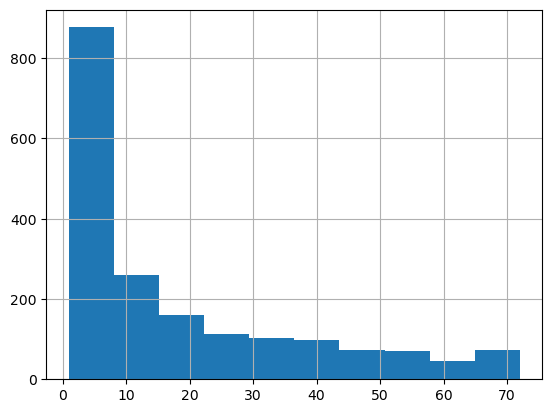

In [92]:
churned_tenure = df[df.churn_yes == True].tenure

churned_tenure.hist()

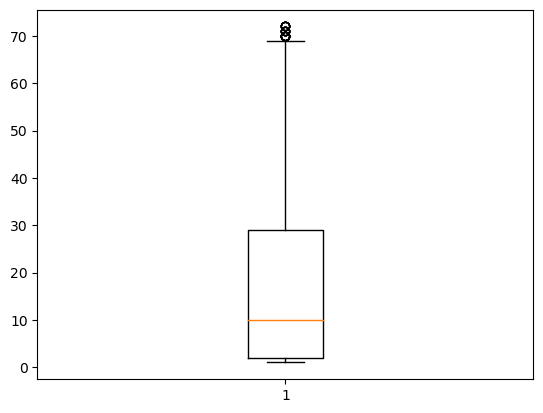

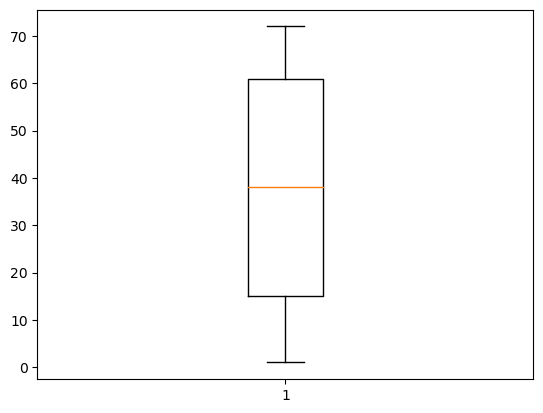

In [111]:
plt.boxplot(df.tenure[df.churn_yes == True])
plt.show()
plt.boxplot(df.tenure[df.churn_yes == False])
plt.show()

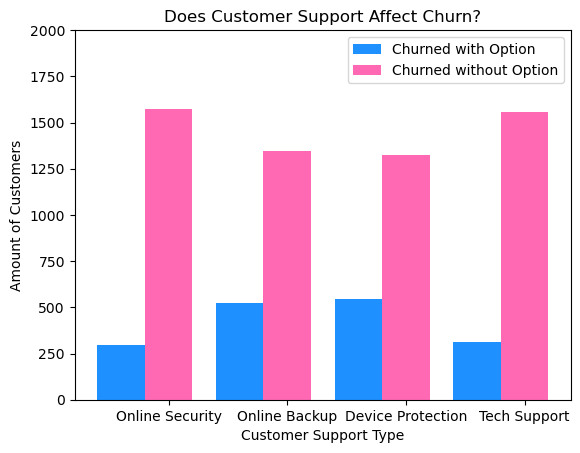

In [115]:
cust_sppt_churned = (295, 523, 545, 310)
no_cust_sppt_churn = (1574, 1346, 1324, 1559)


customer_support = ('Online Security', 'Online Backup', 'Device Protection', 'Tech Support')

width = 0.4
index = np.arange(4)
plt.bar(index, cust_sppt_churned, width = width, 
        label = 'Churned with Option', color = 'dodgerblue')
plt.bar(index + width, no_cust_sppt_churn, width = width, 
        label = 'Churned without Option', color = 'hotpink')

plt.xticks(index + width, customer_support)
plt.ylim (0, 2000)
plt.title('Does Customer Support Affect Churn?')
plt.ylabel('Amount of Customers')
plt.xlabel('Customer Support Type')
plt.legend()

<AxesSubplot:>

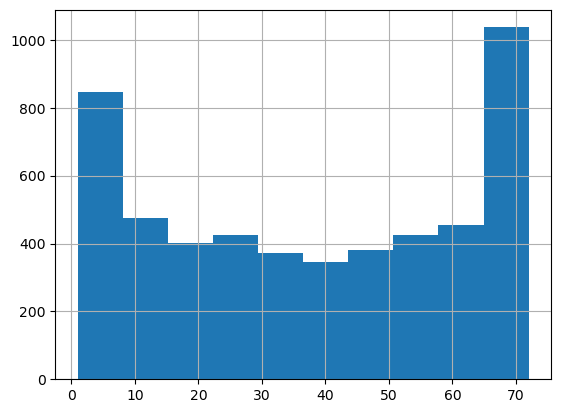

In [116]:
churned_no_tenure = df[df.churn_yes == False].tenure

churned_no_tenure.hist()

In [117]:
print(churned_tenure.var())
print(churned_no_tenure.var())


381.4647677707878
579.6990638317577


In [118]:
t, p = stats.ttest_ind(churned_tenure, churned_no_tenure, equal_var=False)
t, p / 2

(-34.971870097503476, 1.1735373594477435e-234)

In [119]:
print("is p/2 < alpha? ", p / 2 < alpha)
print("is t > 0? ", t > 0)


is p/2 < alpha?  True
is t > 0?  False


In [120]:
if p / 2 > alpha:
    print("We fail to reject $H_{0}$")
elif t < 0:
    print("We fail to reject $H_{0}$")
else:
    print("We reject $H_{0}$")

We fail to reject $H_{0}$


#### Running Chi**2 test on my binary values

In [121]:
tech_sppt = pd.crosstab(df.churn_yes, df.tech_support_yes)
tech_sppt

tech_support_yes,0,1
churn_yes,,
0,3433,1730
1,1559,310


In [122]:
chi2, p, degf, expected = stats.chi2_contingency(tech_sppt)


In [123]:
# print 'Observed Values' followed by a new line
print('Observed Values\n')

# print the values from the 'observed' dataframe
print(tech_sppt.values)

# print --- and then a new line, 'Expected Values', followed by another new line
print('---\nExpected Values\n')

# print the expected values array
print(expected.astype(int))

# print a new line
print('---\n')

# print the chi2 value, formatted to a float with 4 digits. 
print(f'chi^2 = {chi2:.4f}') 

# print the p-value, formatted to a float with 4 digits. 
print(f'p     = {p:.4f}')


Observed Values

[[3433 1730]
 [1559  310]]
---
Expected Values

[[3665 1497]
 [1326  542]]
---

chi^2 = 189.9668
p     = 0.0000


In [124]:
fiber = pd.crosstab(df.churn_yes, df['internet_service_type_fiber optic'])
fiber

internet_service_type_fiber optic,0,1
churn_yes,,
0,3364,1799
1,572,1297


In [125]:
chi2, p, degf, expected = stats.chi2_contingency(fiber)

In [126]:
# print 'Observed Values' followed by a new line
print('Observed Values\n')

# print the values from the 'observed' dataframe
print(fiber.values)

# print --- and then a new line, 'Expected Values', followed by another new line
print('---\nExpected Values\n')

# print the expected values array
print(expected.astype(int))

# print a new line
print('---\n')

# print the chi2 value, formatted to a float with 4 digits. 
print(f'chi^2 = {chi2:.4f}') 

# print the p-value, formatted to a float with 4 digits. 
print(f'p     = {p:.4f}')


Observed Values

[[3364 1799]
 [ 572 1297]]
---
Expected Values

[[2889 2273]
 [1046  822]]
---

chi^2 = 663.3565
p     = 0.0000


In [127]:
no_internet = pd.crosstab(df.churn_yes, df.internet_service_type_none)
no_internet

internet_service_type_none,0,1
churn_yes,,
0,3756,1407
1,1756,113


In [128]:
chi2, p, degf, expected = stats.chi2_contingency(no_internet)

In [129]:
# print 'Observed Values' followed by a new line
print('Observed Values\n')

# print the values from the 'observed' dataframe
print(no_internet.values)

# print --- and then a new line, 'Expected Values', followed by another new line
print('---\nExpected Values\n')

# print the expected values array
print(expected.astype(int))

# print a new line
print('---\n')

# print the chi2 value, formatted to a float with 4 digits. 
print(f'chi^2 = {chi2:.4f}') 

# print the p-value, formatted to a float with 4 digits. 
print(f'p     = {p:.4f}')


Observed Values

[[3756 1407]
 [1756  113]]
---
Expected Values

[[4046 1116]
 [1465  403]]
---

chi^2 = 362.9478
p     = 0.0000


# A 'p' value of 0 means the null hypothesis is rejected and your test is statistically significant (for example the differences between your groups are significant).

<AxesSubplot:xlabel='internet_service_type_fiber optic', ylabel='count'>

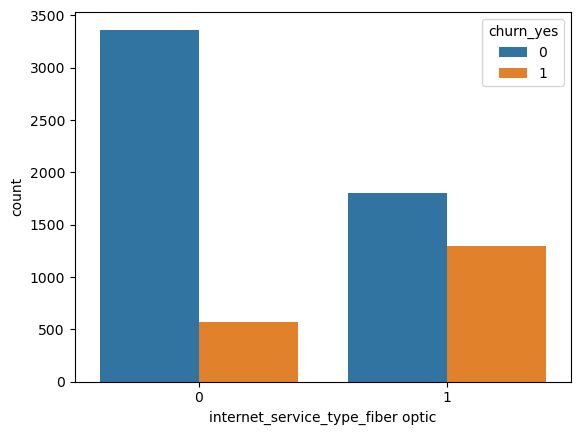

In [130]:
sns.countplot(df['internet_service_type_fiber optic'], hue = df.churn_yes)

<AxesSubplot:xlabel='internet_service_type_none', ylabel='count'>

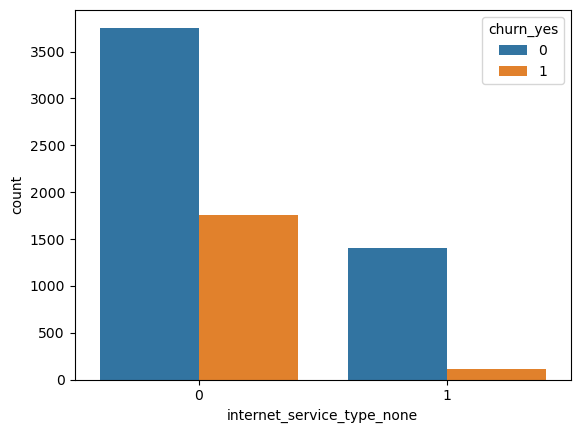

In [131]:
sns.countplot(df['internet_service_type_none'], hue = df.churn_yes)

<AxesSubplot:xlabel='tech_support_yes', ylabel='count'>

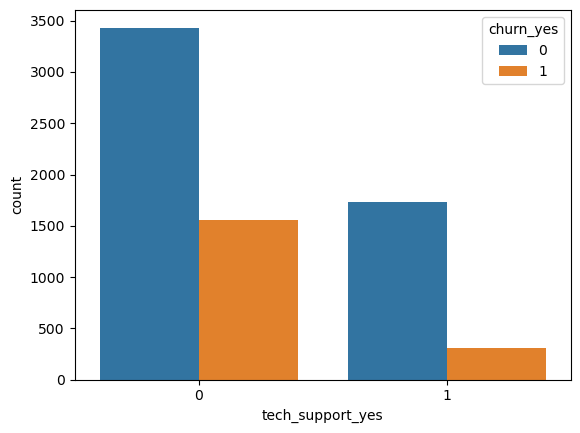

In [132]:
sns.countplot(df['tech_support_yes'], hue = df.churn_yes)

In [133]:
df.churn_yes.value_counts()

0    5163
1    1869
Name: churn_yes, dtype: int64

In [134]:
values = (5163, 1869)

In [135]:
labels = ('Did not churn', 'Churned')

([<matplotlib.patches.Wedge at 0x178d73370>,
 [Text(-0.8054237718986147, 0.8895462594270229, 'Did not churn'),
  Text(0.8054237718986142, -0.8895462594270235, 'Churned')],
 [Text(-0.46983053360752525, 0.5189019846657634, '73.42%'),
  Text(0.4698305336075249, -0.5189019846657636, '26.58%')])

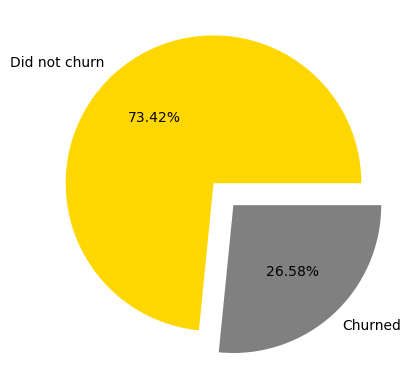

In [136]:
plt.pie(values, labels = labels, autopct = "%.2f%%", explode = (0.1, 0.1), colors = ('gold', 'gray'))

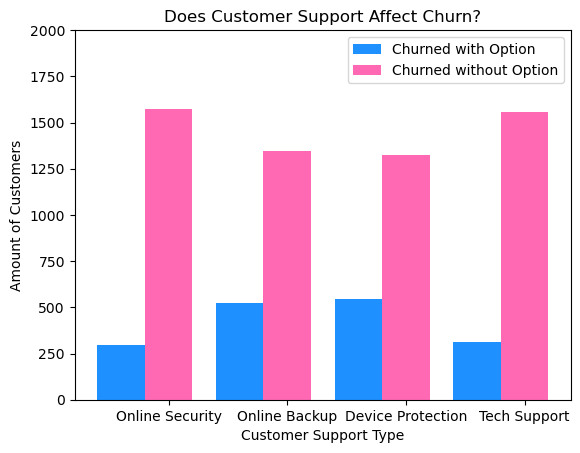

In [137]:
cust_sppt_churned = (295, 523, 545, 310)
no_cust_sppt_churn = (1574, 1346, 1324, 1559)


customer_support = ('Online Security', 'Online Backup', 'Device Protection', 'Tech Support')

width = 0.4
index = np.arange(4)
plt.bar(index, cust_sppt_churned, width = width, 
        label = 'Churned with Option', color = 'dodgerblue')
plt.bar(index + width, no_cust_sppt_churn, width = width, 
        label = 'Churned without Option', color = 'hotpink')

plt.xticks(index + width, customer_support)
plt.ylim (0, 2000)
plt.title('Does Customer Support Affect Churn?')
plt.ylabel('Amount of Customers')
plt.xlabel('Customer Support Type')
plt.legend()

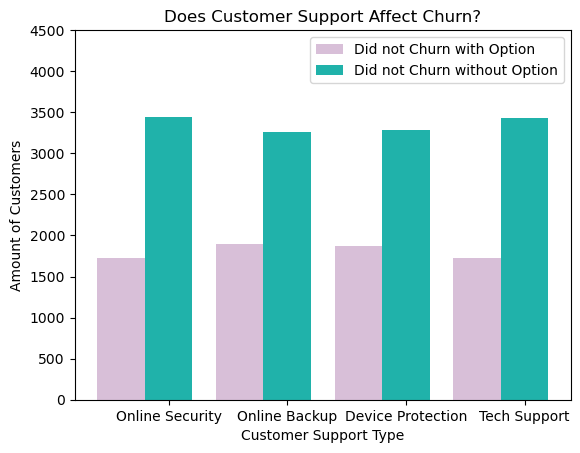

In [138]:
cust_sppt_no_churned = (1720, 1902, 1873, 1730)
no_cust_sppt_no_churn = (3443, 3261, 3290, 3433)


customer_support = ('Online Security', 'Online Backup', 'Device Protection', 'Tech Support')

width = 0.4
index = np.arange(4)
plt.bar(index, cust_sppt_no_churned, width = width, 
        label = 'Did not Churn with Option', color = 'thistle')
plt.bar(index + width, no_cust_sppt_no_churn, width = width, 
        label = 'Did not Churn without Option', color = 'lightseagreen')


plt.xticks(index + width, customer_support)
plt.ylim (0, 4500)
plt.title('Does Customer Support Affect Churn?')
plt.ylabel('Amount of Customers')
plt.xlabel('Customer Support Type')
plt.legend()

In [139]:
X_train = train.drop(columns=['churn_yes'])
y_train = train.churn_yes

X_validate = validate.drop(columns=['churn_yes'])
y_validate = validate.churn_yes

X_test = test.drop(columns=['churn_yes'])
y_test = test.churn_yes

In [140]:
# for classification you can change the algorithm to gini or entropy (information gain).  
# Default is gini.

clf = DecisionTreeClassifier(max_depth=3, random_state=123)


In [141]:
# model.fit(X, y)

clf = clf.fit(X_train, y_train)


In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 15 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   tenure                                 7032 non-null   int64  
 1   monthly_charges                        7032 non-null   float64
 2   total_charges                          7032 non-null   float64
 3   online_security_no internet service    7032 non-null   uint8  
 4   online_security_yes                    7032 non-null   uint8  
 5   online_backup_no internet service      7032 non-null   uint8  
 6   online_backup_yes                      7032 non-null   uint8  
 7   device_protection_no internet service  7032 non-null   uint8  
 8   device_protection_yes                  7032 non-null   uint8  
 9   tech_support_no internet service       7032 non-null   uint8  
 10  tech_support_yes                       7032 non-null   uint8  
 11  pape

In [143]:
X_train.online_security_yes = X_train.online_security_yes.astype(int)

In [144]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4922 entries, 4324 to 248
Data columns (total 14 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   tenure                                 4922 non-null   int64  
 1   monthly_charges                        4922 non-null   float64
 2   total_charges                          4922 non-null   float64
 3   online_security_no internet service    4922 non-null   uint8  
 4   online_security_yes                    4922 non-null   int64  
 5   online_backup_no internet service      4922 non-null   uint8  
 6   online_backup_yes                      4922 non-null   uint8  
 7   device_protection_no internet service  4922 non-null   uint8  
 8   device_protection_yes                  4922 non-null   uint8  
 9   tech_support_no internet service       4922 non-null   uint8  
 10  tech_support_yes                       4922 non-null   uint8  
 11  pa

In [145]:
clf.classes_

array([0, 1], dtype=uint8)

[Text(0.5, 0.875, 'tenure <= 17.5\ngini = 0.39\nsamples = 4922\nvalue = [3614, 1308]\nclass = False'),
 Text(0.25, 0.625, 'internet_service_type_fiber optic <= 0.5\ngini = 0.496\nsamples = 1844\nvalue = [1009, 835]\nclass = False'),
 Text(0.125, 0.375, 'tenure <= 5.5\ngini = 0.408\nsamples = 1058\nvalue = [756, 302]\nclass = False'),
 Text(0.0625, 0.125, 'gini = 0.477\nsamples = 558\nvalue = [339, 219]\nclass = False'),
 Text(0.1875, 0.125, 'gini = 0.277\nsamples = 500\nvalue = [417, 83]\nclass = False'),
 Text(0.375, 0.375, 'total_charges <= 120.0\ngini = 0.437\nsamples = 786\nvalue = [253, 533]\nclass = True'),
 Text(0.3125, 0.125, 'gini = 0.245\nsamples = 168\nvalue = [24, 144]\nclass = True'),
 Text(0.4375, 0.125, 'gini = 0.466\nsamples = 618\nvalue = [229, 389]\nclass = True'),
 Text(0.75, 0.625, 'internet_service_type_fiber optic <= 0.5\ngini = 0.26\nsamples = 3078\nvalue = [2605, 473]\nclass = False'),
 Text(0.625, 0.375, 'online_security_no internet service <= 0.5\ngini = 0.106

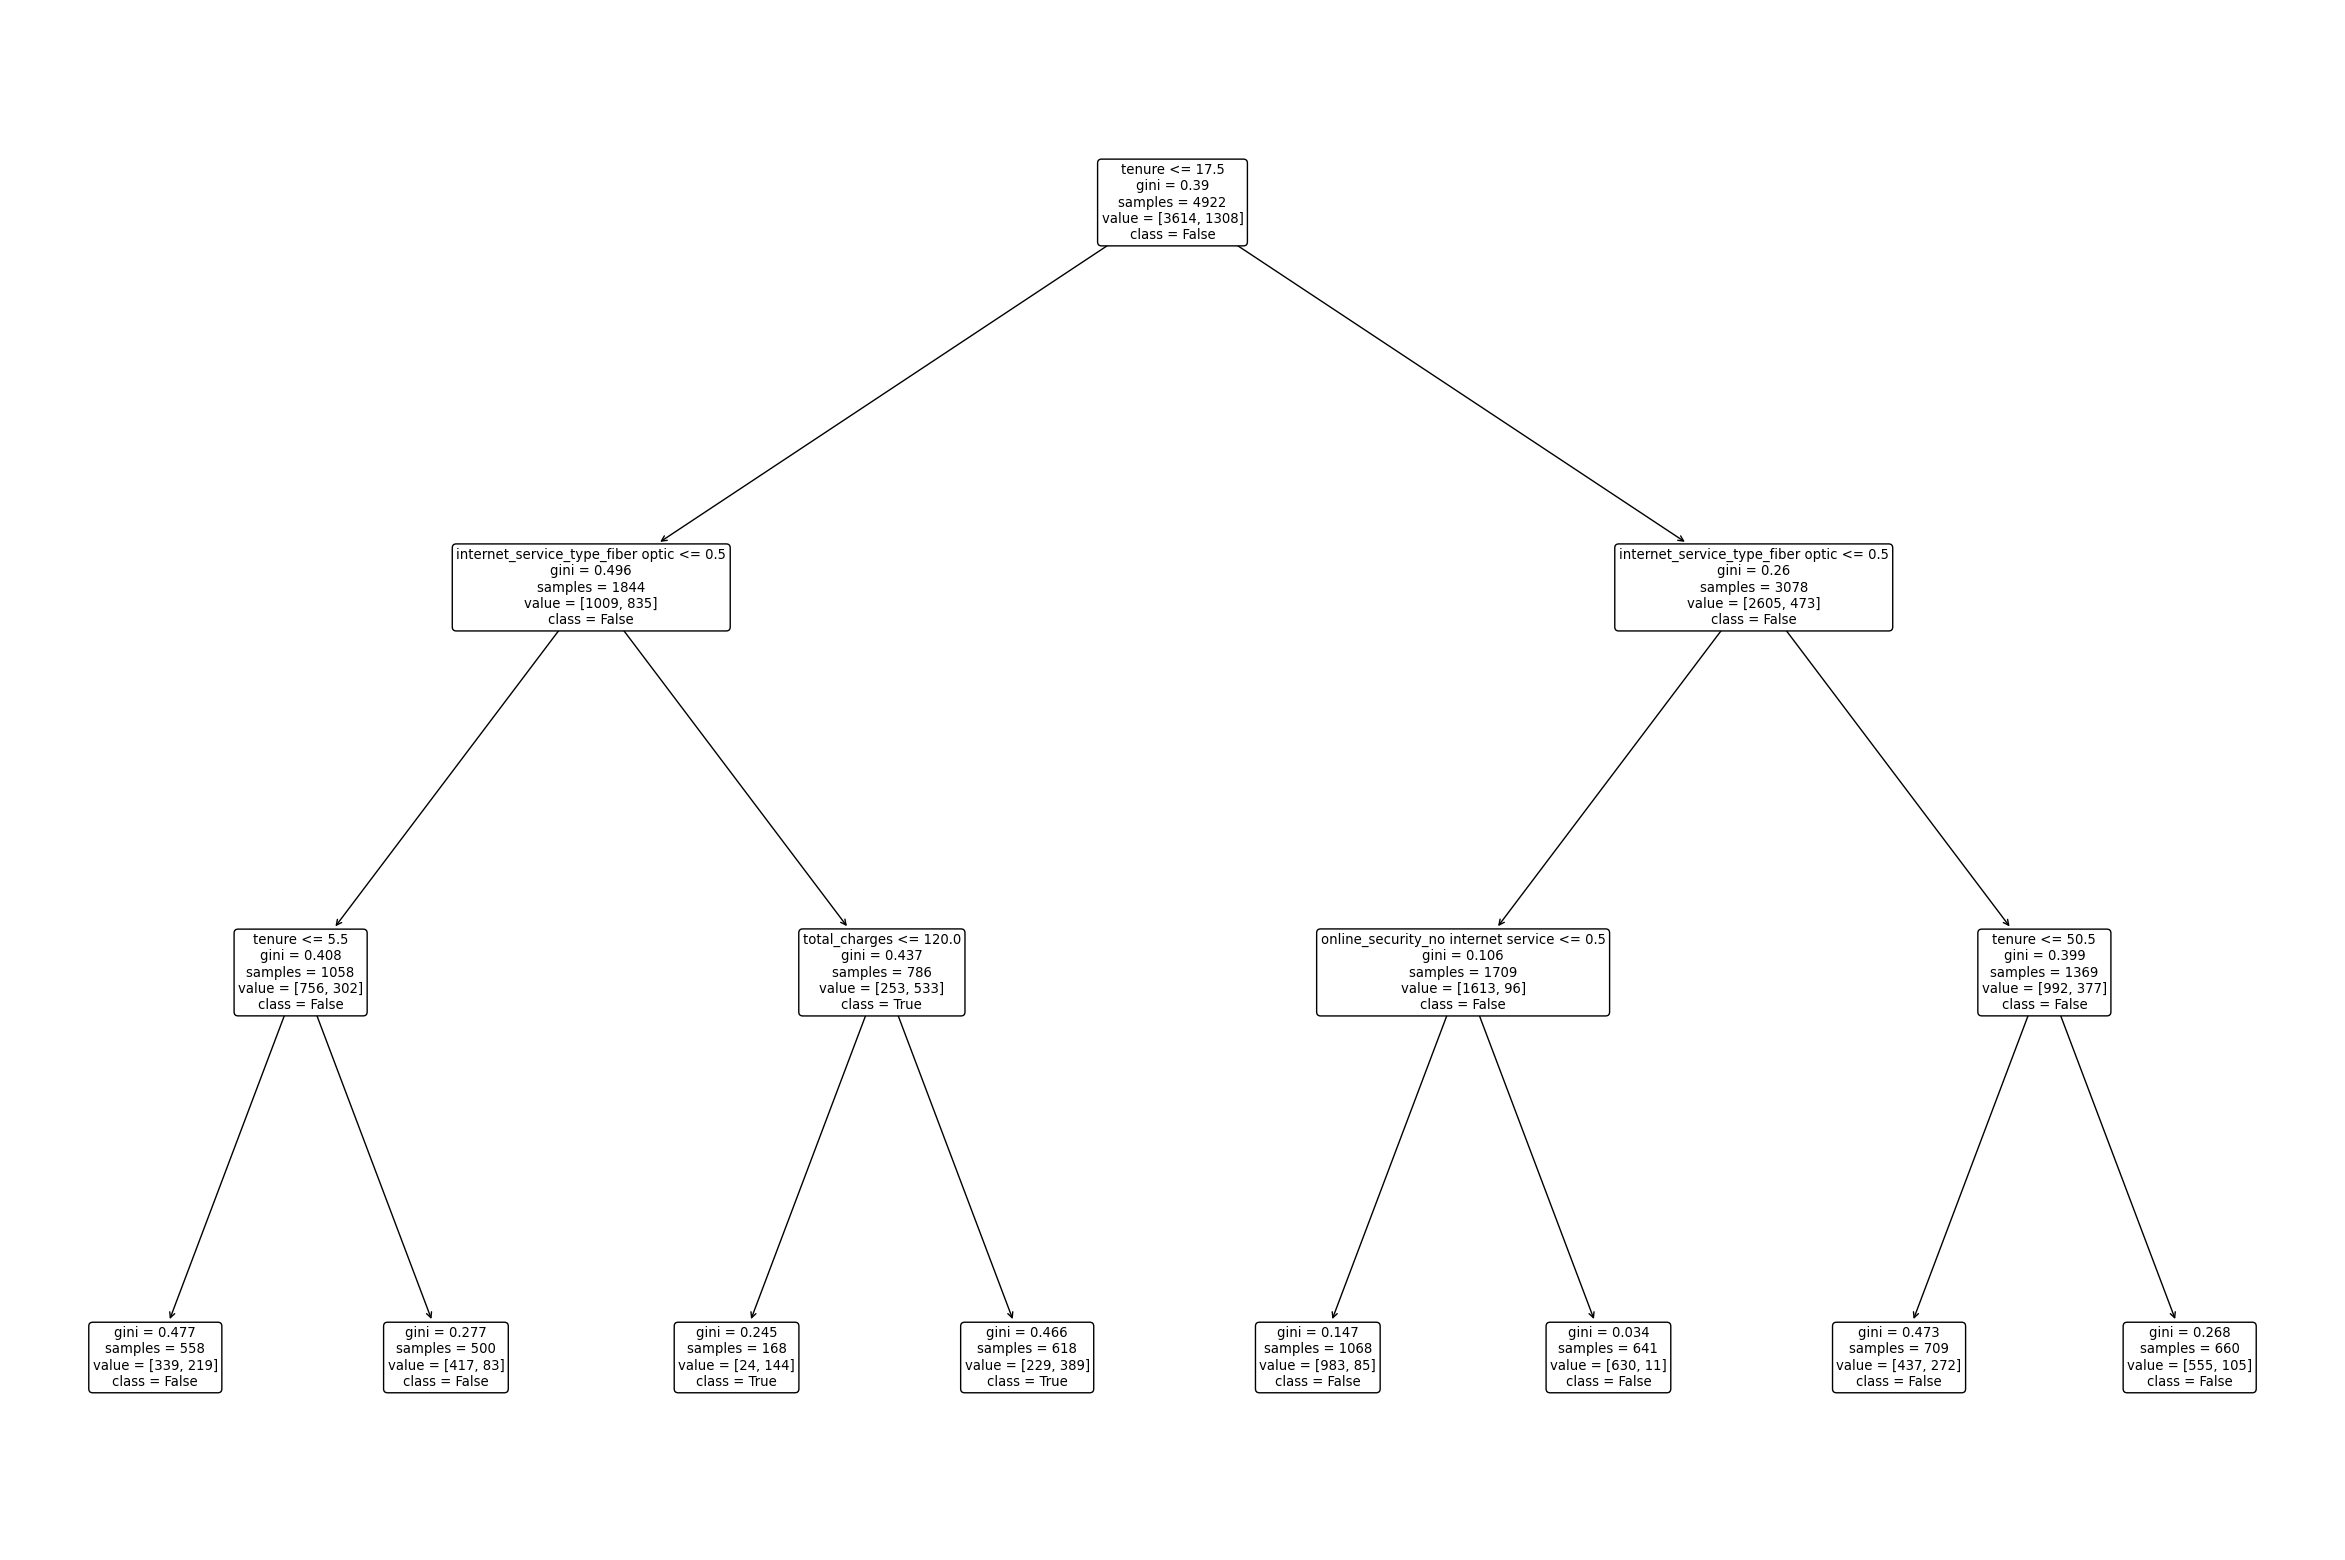

In [146]:
plt.figure(figsize=(30, 20))
plot_tree(clf, feature_names=X_train.columns, class_names=['False', 'True'], rounded=True)


In [147]:
# make prediction on train obeservations

y_pred = clf.predict(X_train)
y_pred[0:5]


array([1, 0, 0, 0, 0], dtype=uint8)

In [148]:
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba[0:5]

array([[0.37055016, 0.62944984],
       [0.98283931, 0.01716069],
       [0.834     , 0.166     ],
       [0.84090909, 0.15909091],
       [0.84090909, 0.15909091]])

In [149]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
      .format(clf.score(X_train, y_train)))


Accuracy of Decision Tree classifier on training set: 0.79


In [150]:
# confusion matrix

confusion_matrix(y_train, y_pred)


array([[3361,  253],
       [ 775,  533]])

In [151]:
y_train.value_counts()


0    3614
1    1308
Name: churn_yes, dtype: int64

In [152]:
labels = sorted(y_train.unique())

pd.DataFrame(confusion_matrix(y_train, y_pred), index=labels, columns=labels)


,0,1
0,3361,253
1,775,533


In [153]:
print(classification_report(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.81      0.93      0.87      3614
           1       0.68      0.41      0.51      1308

    accuracy                           0.79      4922
   macro avg       0.75      0.67      0.69      4922
weighted avg       0.78      0.79      0.77      4922



In [154]:
print('Accuracy of Decision Tree classifier on validate set: {:.2f}'
     .format(clf.score(X_validate, y_validate)))


Accuracy of Decision Tree classifier on validate set: 0.79


In [155]:
# And since accuracy isn't everything

# Produce y_predictions that come from the X_validate
y_pred = clf.predict(X_validate)

# Compare actual y values (from validate) to predicted y_values from the model run on X_validate
print(classification_report(y_validate, y_pred))


              precision    recall  f1-score   support

           0       0.81      0.93      0.87      1239
           1       0.68      0.41      0.52       449

    accuracy                           0.79      1688
   macro avg       0.75      0.67      0.69      1688
weighted avg       0.78      0.79      0.77      1688

